In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
data = train.copy()

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


- **Kategorik değişkenkeri** ve bizim belirlediğimiz sayının altında benzersiz veriye sahip değişkenleri alalım.

- **Ordinal Değişkenler** ; Ordinal veriler de yine kategorik veri türündendir. Fakat değerleri arasında sıralı bir ilişki bulunmaktadır.

- Bu değişkenleri veren bir fonksiyon yazalım.

In [5]:
def Feature_Names(df,cat_number):
    
    # Kategorik Değişkenleri alalım
    cat_cols = [cols for cols in df.columns if data[cols].dtypes == "object"]
    
    # Numeric Ama kategoric olan Değişkenleri alalım
    num_cat = [cols for cols in df.columns if data[cols].nunique() < int(cat_number)
              and data[cols].dtypes != 'object']
    
    # Numeric Değişkenleri alalım
    num_cols = [cols for cols in df.columns if data[cols].dtypes != 'object']
    
    # Numeric ama kategorik değişkenler arasında olmayacak bu numerik değişlenlerimiz 
    num_cols = [cols for cols in num_cols if cols not in num_cat] 
    
    for i in range(1):
        
        print("#######################################################")
        print(f"Kategorik Değişkenler : {cat_cols}\nToplam Kategorik Değişken Sayısı : {len(cat_cols)}")
    for i in range(1):
        
        print("##########################################################")
        print(f"Kategorik ama Numeric Değişkenler : {num_cat}\nToplam Kategorik ama Numeric Değişken Sayısı : {len(num_cat)}")
    for i in range(1):
        
        print("#########################################################")
        print(f"Numeric Değişkenler : {num_cols}\nToplam Numeric Değişken Sayısı : {len(num_cols)}")
        
       
    #return cat_cols, num_cat, num_cols
Feature_Names(data,cat_number=10)    

#######################################################
Kategorik Değişkenler : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Toplam Kategorik Değişken Sayısı : 43
##########################################################
Kategorik ama Numeric Değişkenler : ['OverallCond', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'PoolArea', 'YrSold']
Toplam Kategorik ama Numeric Değişken Sayısı : 11
###

# Kategorik Değişkenler 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

- Kategorik Değişkenlerimizi alalım 

In [7]:
def Cat_Cols(df):
    
    cat_cols = [cols for cols in df.columns if df[cols].dtype == 'object']
    
    for cols in cat_cols:
        
        data_new = pd.DataFrame({cols:df[cols].value_counts(),'Oran':df[cols].value_counts() / len(df)})
        
        print(f"#######################################################")
        print(data_new, end = "\n\n")
   

 

Cat_Cols(data)    

#######################################################
         MSZoning      Oran
RL           1151  0.788356
RM            218  0.149315
FV             65  0.044521
RH             16  0.010959
C (all)        10  0.006849

#######################################################
      Street     Oran
Pave    1454  0.99589
Grvl       6  0.00411

#######################################################
      Alley      Oran
Grvl     50  0.034247
Pave     41  0.028082

#######################################################
     LotShape      Oran
Reg       925  0.633562
IR1       484  0.331507
IR2        41  0.028082
IR3        10  0.006849

#######################################################
     LandContour      Oran
Lvl         1311  0.897945
Bnk           63  0.043151
HLS           50  0.034247
Low           36  0.024658

#######################################################
        Utilities      Oran
AllPub       1459  0.999315
NoSeWa          1  0.000685

###################

- Numeric Ama Kategorik olan değişkenlerimizi alacağız.
- Benzersiz verileri 10'dan küçük olan Değişkenleri alacağız.
- Değişkenlerimizin Benzersiz verilerinin toplam Data sayımıza oranını bulucağız
- Değişkenlerimizi görselleştireceğiz.
- Bu hepsini bize veren bir fonskiyon yazacağız.

######################################################
   OverallCond      Oran
5          821  0.562329
6          252  0.172603
7          205  0.140411
8           72  0.049315
4           57  0.039041
3           25  0.017123
9           22  0.015068
2            5  0.003425
1            1  0.000685


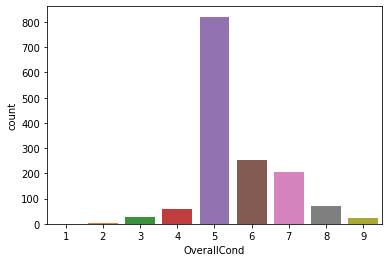

######################################################
   BsmtFullBath      Oran
0           856  0.586301
1           588  0.402740
2            15  0.010274
3             1  0.000685


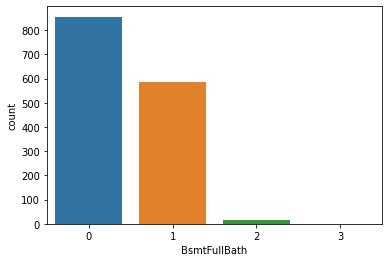

######################################################
   BsmtHalfBath      Oran
0          1378  0.943836
1            80  0.054795
2             2  0.001370


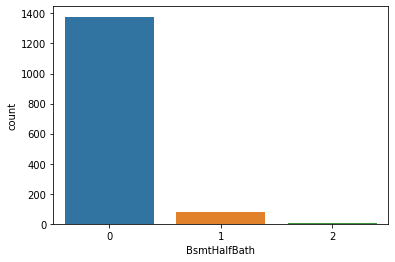

######################################################
   FullBath      Oran
2       768  0.526027
1       650  0.445205
3        33  0.022603
0         9  0.006164


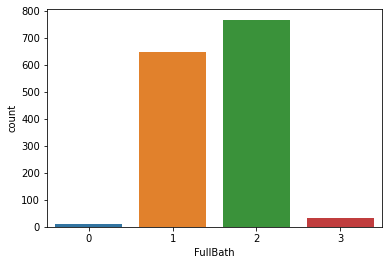

######################################################
   HalfBath      Oran
0       913  0.625342
1       535  0.366438
2        12  0.008219


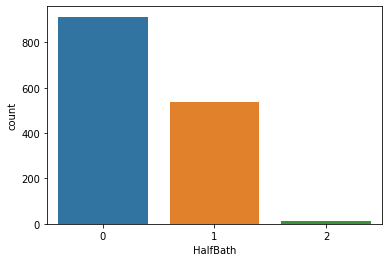

######################################################
   BedroomAbvGr      Oran
3           804  0.550685
2           358  0.245205
4           213  0.145890
1            50  0.034247
5            21  0.014384
6             7  0.004795
0             6  0.004110
8             1  0.000685


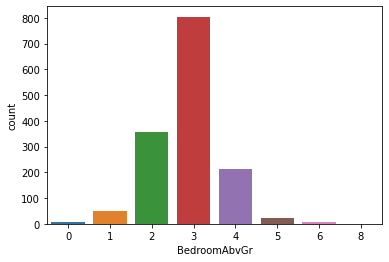

######################################################
   KitchenAbvGr      Oran
1          1392  0.953425
2            65  0.044521
3             2  0.001370
0             1  0.000685


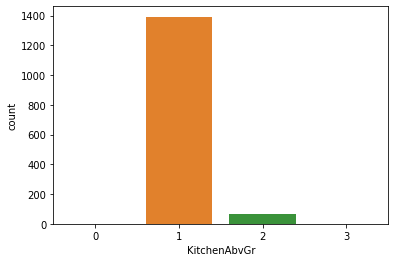

######################################################
   Fireplaces      Oran
0         690  0.472603
1         650  0.445205
2         115  0.078767
3           5  0.003425


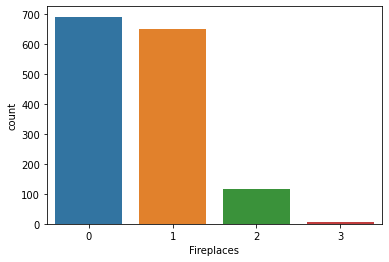

######################################################
   GarageCars      Oran
2         824  0.564384
1         369  0.252740
3         181  0.123973
0          81  0.055479
4           5  0.003425


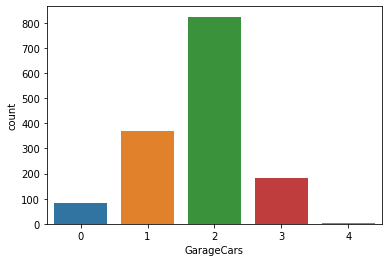

######################################################
     PoolArea      Oran
0        1453  0.995205
480         1  0.000685
512         1  0.000685
519         1  0.000685
555         1  0.000685
576         1  0.000685
648         1  0.000685
738         1  0.000685


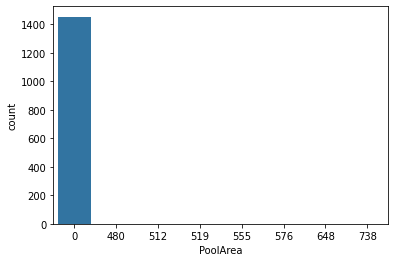

######################################################
      YrSold      Oran
2009     338  0.231507
2007     329  0.225342
2006     314  0.215068
2008     304  0.208219
2010     175  0.119863


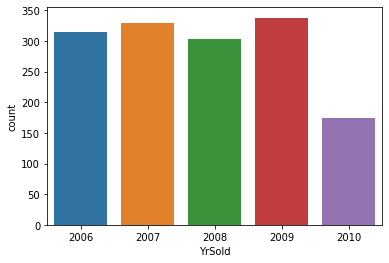

In [8]:
def Num_Cat_Cols(df, cat_number, plot = False):
        
    num_cat = [cols for cols in df.columns if df[cols].nunique() < int(cat_number)
              and df[cols].dtype != 'object']
        
    for cols in num_cat:
               
        print(f"######################################################") 
        data_new = pd.DataFrame({cols:df[cols].value_counts(),'Oran':df[cols].value_counts() / len(df)})
        print(data_new, end = "\n")
        
        if plot:
            
            sns.countplot(x=cols, data=df)
            plt.show()

Num_Cat_Cols(data, cat_number = 10, plot=True)

# Sayısal Değer

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


- Numeric yani Sayısal Değişkenlerimizi alacağız.
- Değişkenlerimizin Histogram görselleştireceğiz.

######################## Id #############################


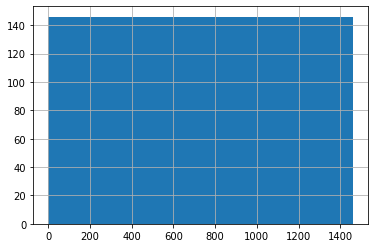

######################## MSSubClass #############################


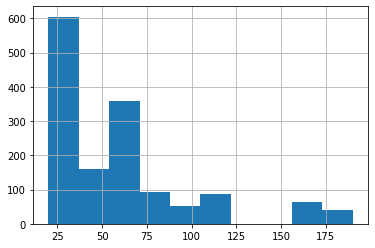

######################## LotFrontage #############################


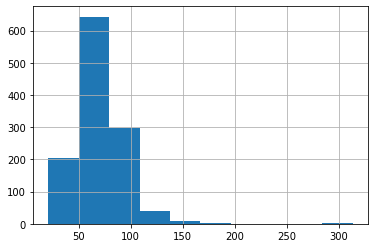

######################## LotArea #############################


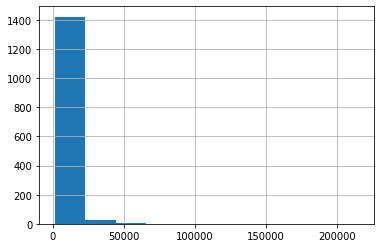

######################## OverallQual #############################


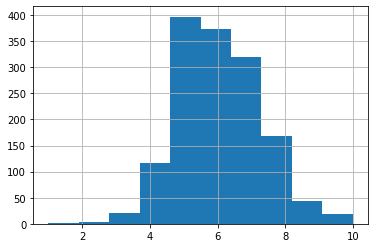

######################## OverallCond #############################


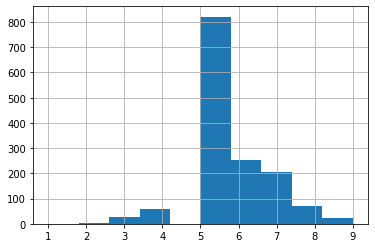

######################## YearBuilt #############################


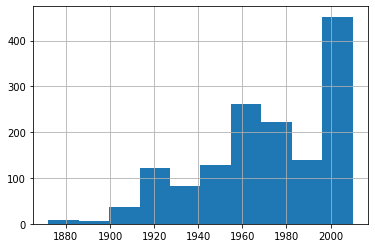

######################## YearRemodAdd #############################


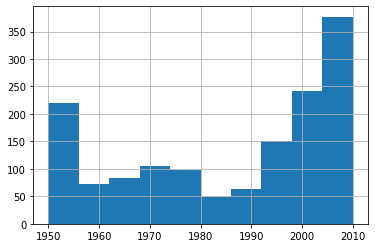

######################## MasVnrArea #############################


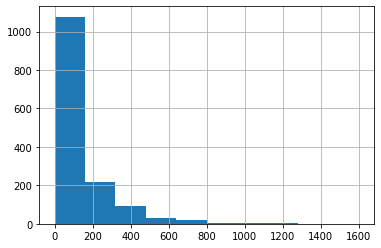

######################## BsmtFinSF1 #############################


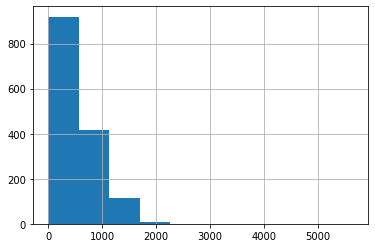

######################## BsmtFinSF2 #############################


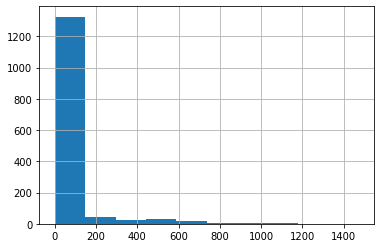

######################## BsmtUnfSF #############################


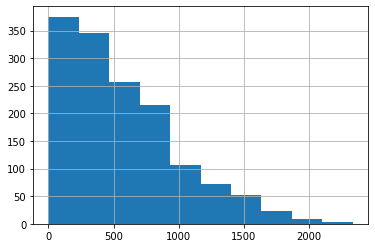

######################## TotalBsmtSF #############################


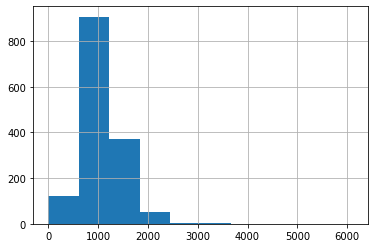

######################## 1stFlrSF #############################


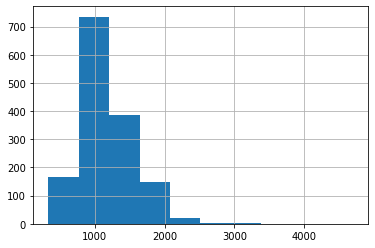

######################## 2ndFlrSF #############################


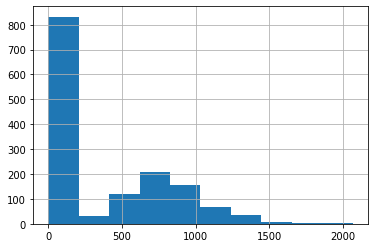

######################## LowQualFinSF #############################


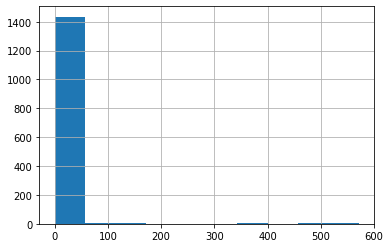

######################## GrLivArea #############################


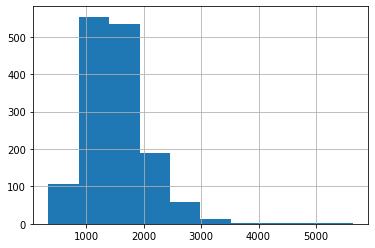

######################## BsmtFullBath #############################


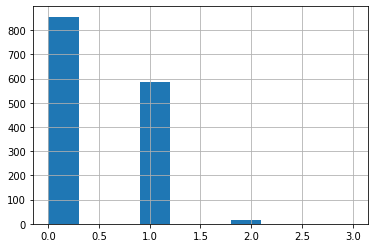

######################## BsmtHalfBath #############################


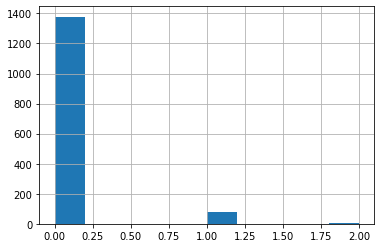

######################## FullBath #############################


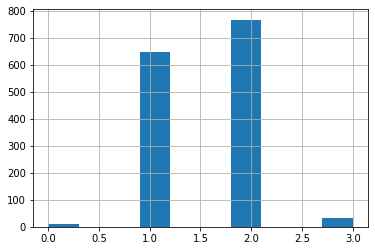

######################## HalfBath #############################


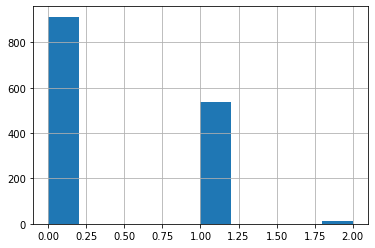

######################## BedroomAbvGr #############################


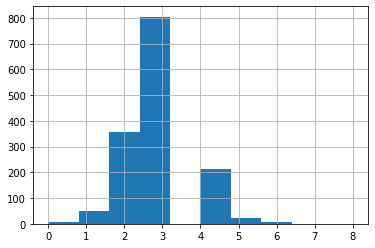

######################## KitchenAbvGr #############################


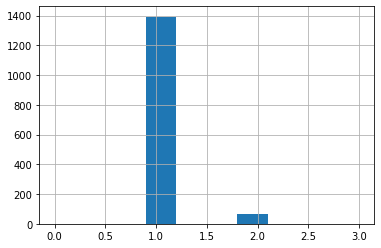

######################## TotRmsAbvGrd #############################


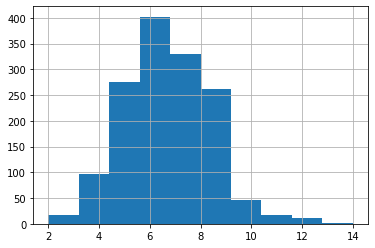

######################## Fireplaces #############################


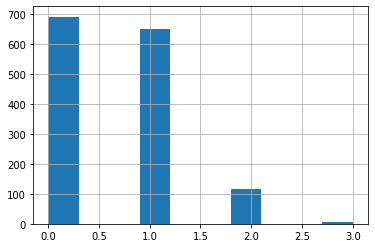

######################## GarageYrBlt #############################


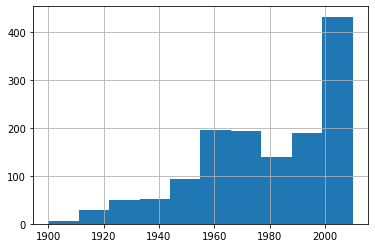

######################## GarageCars #############################


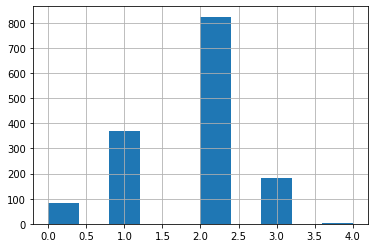

######################## GarageArea #############################


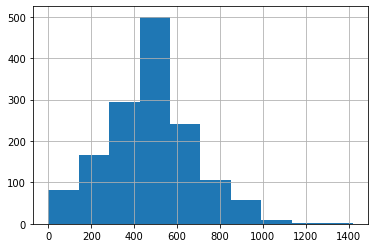

######################## WoodDeckSF #############################


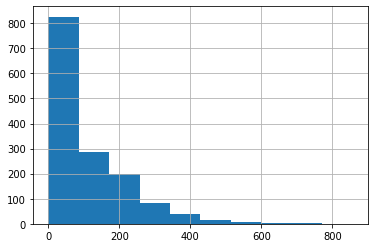

######################## OpenPorchSF #############################


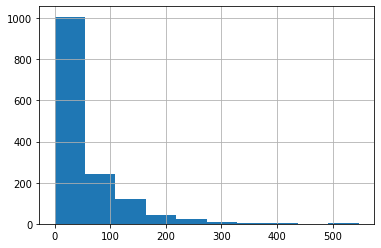

######################## EnclosedPorch #############################


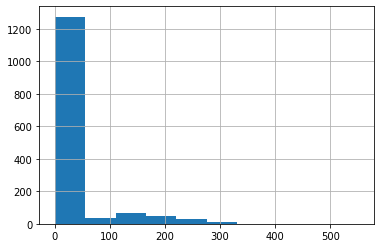

######################## 3SsnPorch #############################


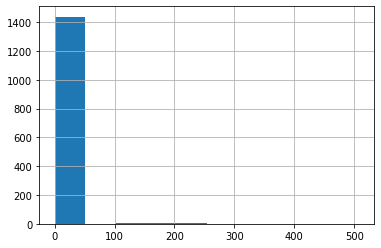

######################## ScreenPorch #############################


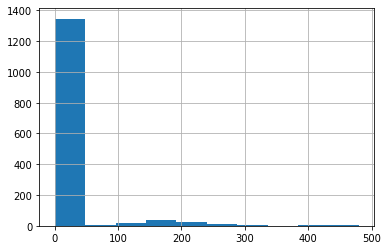

######################## PoolArea #############################


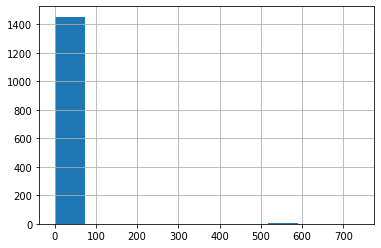

######################## MiscVal #############################


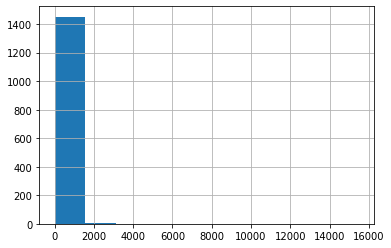

######################## MoSold #############################


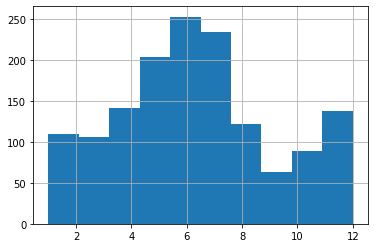

######################## YrSold #############################


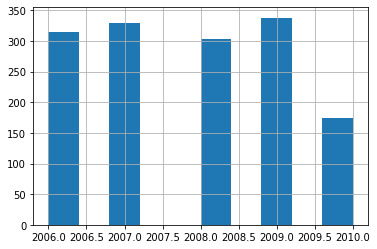

######################## SalePrice #############################


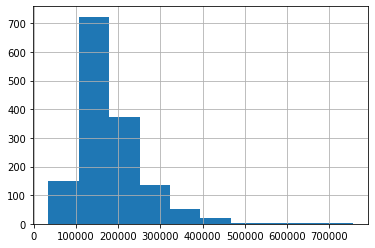

In [10]:
def Numeric(df, plot = False):
    
    num_cols = [cols for cols in data.columns if df[cols].dtypes != 'object']
    
    for cols in num_cols:
        
        if plot:
            
            print(f"######################## {cols} #############################")
            df[cols].hist()
            plt.show()

Numeric(data, plot=True)            

# Hedef Değişken Analizi 

- Bizim Hedef Değişkenimiz **SalePrice** değişkenidir.
- Hedef Değişkenimiz ile Benzersiz Veri sayısı 10'dan küçük olan değişkenlerimize göre gruplayıp,
  **ortalama** alıyoruz.

In [11]:
def Target(df, cat_number = 10, target = 'SalePrice'):
    
    cat_cols = [cols for cols in df.columns if df[cols].nunique() < int(cat_number)]
    
    for cols in cat_cols:

        data_new = pd.DataFrame({'Hedef Ortalama': df.groupby(cols)[target].mean()})
        print("##############################################")
        print(data_new, end = "\n\n")
        
Target(df = data, cat_number = 10, target = "SalePrice")

##############################################
          Hedef Ortalama
MSZoning                
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275

##############################################
        Hedef Ortalama
Street                
Grvl     130190.500000
Pave     181130.538514

##############################################
       Hedef Ortalama
Alley                
Grvl    122219.080000
Pave    168000.585366

##############################################
          Hedef Ortalama
LotShape                
IR1        206101.665289
IR2        239833.365854
IR3        216036.500000
Reg        164754.818378

##############################################
             Hedef Ortalama
LandContour                
Bnk           143104.079365
HLS           231533.940000
Low           203661.111111
Lvl           180183.746758

##############################################
           Hedef Ortalama
Utilities     

# Sayısal Değişken 

In [12]:
num_cols = [cols for cols in data.columns if data[cols].dtype != 'object']

num_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [13]:
data.groupby('SalePrice').agg({'PoolArea':'max','GarageArea':'mean','FullBath':'min'})

,PoolArea,GarageArea,FullBath
SalePrice,,,
34900,0,0.0,1
35311,0,308.0,0
37900,0,0.0,1
39300,0,0.0,1
40000,0,250.0,1
...,...,...,...
582933,0,1020.0,3
611657,0,820.0,2
625000,0,807.0,3


- Sayısal Değişkenlerimizin, **Korelasyonuna** Bakalım

In [14]:
data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


In [15]:
def correlation(df,num_cols, target='SalePrice',corr_limit=0.50):
    
    high = []
    
    low = []
    
    for cols in num_cols:
        
        if cols == 'SalePrice':
            pass
        else:
            
            corr = df[[cols,target]].corr().loc[cols, target]
            
            if abs(corr) > corr_limit: #abs() fonksiyonu mutlak değer alır.
                
                high.append(cols  + ":" + str(corr))
            else:
                low.append(cols + ":" + str(corr))
                
    cache = {'Low Correlations Features':low,'High Correlations Features':high}    
                      
    return cache

num_cols = [cols for cols in data.columns if data[cols].dtype != 'object']

correlation(data,num_cols,target='SalePrice',corr_limit=0.50)

{'Low Correlations Features': ['Id:-0.021916719443430967',
  'MSSubClass:-0.08428413512659509',
  'LotFrontage:0.35179909657067737',
  'LotArea:0.2638433538714051',
  'OverallCond:-0.07785589404867797',
  'MasVnrArea:0.47749304709571444',
  'BsmtFinSF1:0.3864198062421535',
  'BsmtFinSF2:-0.011378121450215146',
  'BsmtUnfSF:0.21447910554696928',
  '2ndFlrSF:0.31933380283206736',
  'LowQualFinSF:-0.02560613000067955',
  'BsmtFullBath:0.22712223313149427',
  'BsmtHalfBath:-0.01684415429735895',
  'HalfBath:0.28410767559478256',
  'BedroomAbvGr:0.16821315430073963',
  'KitchenAbvGr:-0.13590737084214105',
  'Fireplaces:0.46692883675152763',
  'GarageYrBlt:0.4863616774878596',
  'WoodDeckSF:0.32441344456812926',
  'OpenPorchSF:0.31585622711605504',
  'EnclosedPorch:-0.1285779579259566',
  '3SsnPorch:0.04458366533574838',
  'ScreenPorch:0.11144657114291112',
  'PoolArea:0.09240354949187318',
  'MiscVal:-0.021189579640303213',
  'MoSold:0.046432245223819446',
  'YrSold:-0.028922585168736813'],

# Missing Values

In [16]:
data.isnull().values.any()

True

In [17]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [18]:
data.isnull().sum().sum()

6965

In [19]:
data.columns[data.isnull().any()].tolist()

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

- **Eksik veriye sahip değişkenleri** verir

In [20]:
data[data.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


- Tam olan gözlerm birimlerini verir.

In [21]:
data[data.notnull().all(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [22]:
[cols for cols in data.columns if data[cols].isnull().any()]

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

,Feature,num_missing,Datatypes
0,PoolQC,1453,object
1,MiscFeature,1406,object
2,Alley,1369,object
3,Fence,1179,object
4,FireplaceQu,690,object
5,LotFrontage,259,float64
6,GarageYrBlt,81,float64
7,GarageCond,81,object
8,GarageType,81,object
9,GarageFinish,81,object


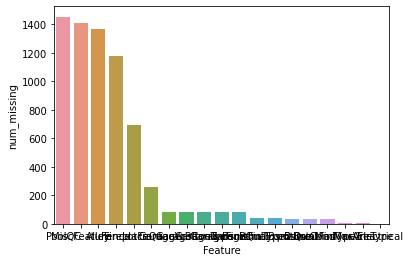

In [23]:
def miss_value(df, plot= False):
    
    data_new = pd.DataFrame({'num_missing':df.isnull().sum()})
    
    data_new['Datatypes'] = data[data_new.index].dtypes.values
    
    data_new = data_new.sort_values('num_missing', ascending = False)
    
    data_new = data_new[data_new['num_missing'] > 0].reset_index().rename({'index':'Feature'}, axis=1)    
          
    if plot:
        
        sns.barplot(x=data_new['Feature'], y = data_new['num_missing']);
        
    return data_new
    
    
        
data_new = miss_value(data, plot=True)

data_new 

- **Eksik Değerler** 'in olduğu data_new'deki **Feature**'lardan , **Object** data tipine sahip olan **değişkenleri** aldık.

In [24]:
data_new['Feature'][data_new['Datatypes'] == 'object']

0           PoolQC
1      MiscFeature
2            Alley
3            Fence
4      FireplaceQu
7       GarageCond
8       GarageType
9     GarageFinish
10      GarageQual
11    BsmtFinType2
12    BsmtExposure
13        BsmtQual
14        BsmtCond
15    BsmtFinType1
17      MasVnrType
18      Electrical
Name: Feature, dtype: object

- Eksik Değere Sahip Değişkenlerimizin tipinin **object** olanların benzersiz verilerine bakacağız

In [25]:
def missObjectcount(df,df_new):
    
    object_cols = df_new['Feature'][df_new['Datatypes'] == 'object']
    
    for cols in object_cols:
        
        df_data = pd.DataFrame({'Count':df[cols].value_counts()})
        
        print(f"####################  {cols}  ###########################")
        
        print(f"{df_data}\nToplam Eksik Değer Sayısı = {df[cols].isnull().sum()}", end = "\n\n")
        
    print(f"Toplam Eksik Değere Sahip Object Tipli değişken : {len(object_cols)}")
        
        
        
missObjectcount(data,data_new)    

####################  PoolQC  ###########################
    Count
Gd      3
Fa      2
Ex      2
Toplam Eksik Değer Sayısı = 1453

####################  MiscFeature  ###########################
      Count
Shed     49
Othr      2
Gar2      2
TenC      1
Toplam Eksik Değer Sayısı = 1406

####################  Alley  ###########################
      Count
Grvl     50
Pave     41
Toplam Eksik Değer Sayısı = 1369

####################  Fence  ###########################
       Count
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Toplam Eksik Değer Sayısı = 1179

####################  FireplaceQu  ###########################
    Count
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Toplam Eksik Değer Sayısı = 690

####################  GarageCond  ###########################
    Count
TA   1326
Fa     35
Gd      9
Po      7
Ex      2
Toplam Eksik Değer Sayısı = 81

####################  GarageType  ###########################
         Count
Attchd     870
Detchd     387
BuiltIn    

- Bu **Object data tipine sahip** olan eksik değerleri olan değişkenler arasından;
   
   - Eksik Değer toplamı 100'den fazla olanı ve az olanı bıze veren fonksiyon yazalım.

In [26]:
def miss_count(df):
    
    up_count = []
    
    low_count = []
    
    data_x = [cols for cols in df.columns if df[cols].isnull().any()
             and df[cols].dtypes == 'object']
    
    for cols in data_x:
        
        count = df[cols].isnull().sum()
        
        if count > 100:
            
            up_count.append((cols,count))
        else:
            low_count.append((cols,count))
            
    return low_count, up_count
        
low,up = miss_count(data)
low, up

([('MasVnrType', 8),
  ('BsmtQual', 37),
  ('BsmtCond', 37),
  ('BsmtExposure', 38),
  ('BsmtFinType1', 37),
  ('BsmtFinType2', 38),
  ('Electrical', 1),
  ('GarageType', 81),
  ('GarageFinish', 81),
  ('GarageQual', 81),
  ('GarageCond', 81)],
 [('Alley', 1369),
  ('FireplaceQu', 690),
  ('PoolQC', 1453),
  ('Fence', 1179),
  ('MiscFeature', 1406)])

In [27]:
[cols for cols in data.columns if data[cols].isnull().any()
and data[cols].dtypes != 'object']

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

- **Toplam Eksik Değer Sayısı 100'ün altında** olan Değişkenlerimizin eksik değerlerini , Değişkenlerimizin **Mode'unu alarak** doldurduk.
- **Toplam Eksik Değer Sayısı 100'ün üstünde** olan Değişkenlerimizin eksik değerlerini , **None** ile doldurduk.

In [28]:
def miss_fill(df):
    
    miss_cols = [cols for cols in df.columns if df[cols].isnull().any()
                and df[cols].dtypes == 'object']
    
    low_cols = [cols for cols in miss_cols if df[cols].isnull().sum() < 100]
    
    print("##### 100'ün Altında Eksik Değere Sahip Object Değişkenler #####")
    
    for cols in low_cols: #100'ün altında eksik değeri olan object değişkenler
        
        df[cols] = df[cols].fillna(df[cols].mode()[0])
        
        print(f"{df[cols].name} = {df[cols].isnull().any()}")
        
    up_cols = [cols for cols in miss_cols if df[cols].isnull().sum() > 100]
    
    print("##### 100'ün Üstünde Eksik Değere Sahip Object Değişkenler #####")
    
    for cols in up_cols: #100'ün üstünde eksik değer olan object değişkenler
        
        df[cols] = df[cols].fillna("None")
        
        print(f"{df[cols].name} = {df[cols].isnull().any()}" )

miss_fill(data)

##### 100'ün Altında Eksik Değere Sahip Object Değişkenler #####
MasVnrType = False
BsmtQual = False
BsmtCond = False
BsmtExposure = False
BsmtFinType1 = False
BsmtFinType2 = False
Electrical = False
GarageType = False
GarageFinish = False
GarageQual = False
GarageCond = False
##### 100'ün Üstünde Eksik Değere Sahip Object Değişkenler #####
Alley = False
FireplaceQu = False
PoolQC = False
Fence = False
MiscFeature = False


- **Object** değişkene sahip olmayan **Eksik Değere** sahip değişkenlerimizi alalım

In [29]:
[cols for cols in data.columns if data[cols].isnull().any()
and data[cols].dtypes != 'object']

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

- **Object** data tipine sahip olmayan **Eksik Değere** Sahip değişkenlerimizin, *Eksik Değerlerini* **Mode**'u ile dolduracağız 

In [30]:
def miss_flo(df):
    
    miss_cols = [cols for cols in df.columns if df[cols].isnull().any()
                and df[cols].dtypes != 'object']
    
    for cols in miss_cols:
        
        df[cols] = df[cols].fillna(df[cols].mode()[0])
        
        print(f"{df[cols].name} = {df[cols].isnull().any()}")
        
miss_flo(data)

LotFrontage = False
MasVnrArea = False
GarageYrBlt = False


- Datamızda ki eksik değerleri doldurduk.Kontrol edelim !

In [31]:
data.isnull().any().sum()

0

# Outliers

In [32]:
num_cols = [cols for cols in data.columns if data[cols].dtypes != 'object'
           and cols not in 'Id' and cols not in 'SalePrice']
num_cols, len(num_cols)

(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold'],
 36)

- Değişkenlerimizin, **Alt Eşik** ve **Üst Eşik** Değerlerinin bize veren fonksiyon yazalım


In [33]:
def alt_üst_eşik(df,feature):
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = np.multiply(1.5, np.subtract(Q3,Q1))
        
    alt_eşik = IQR - Q1
    üst_eşik = IQR + Q3
        
    return alt_eşik, üst_eşik
        
        
alt,üst = alt_üst_eşik(data,feature = "MSSubClass")

alt, üst

(55.0, 145.0)

- Bir Değişkende **Aykırı Değer Olup Olmadığını** kontrol eden fonksiyon yazalım

In [34]:
def variable_Out(df,feature):
    
    result = []
    
    alt, üst = alt_üst_eşik(df, feature) # alt, üst eşik değerlerinin veren fonksiyonu kullandık
    
    #out_num = df[feature][(df[feature] < alt) | (df[feature] > üst)].count()
    
    if df[feature][(df[feature] <alt) | (df[feature] > üst)].any(axis=None): 
    
    #if out_num > 0:    
        
        result.append("Yes")
    else:
        result.append("No")
        
    return result
        
    
variable_Out(data,feature = 'LotFrontage')  

['Yes']

In [35]:
variable_Out(data, feature = 'SalePrice')

['Yes']

In [36]:
data['MSSubClass'][(data['MSSubClass'] < alt) | (data['MSSubClass'] > üst)].count()

868

In [37]:
data['MSSubClass'][(data['MSSubClass'] < alt)].count()

765

In [38]:
 data['MSSubClass'][(data['MSSubClass'] > üst)].count()

103

- **Aykırı Değeri olan** değişkenleri bize veren, **alt ve üst eşik değerlerini** bize veren fonksiyon yazalım.

In [39]:
def Outliers(df):
    
    aykırı = []
    
    aykırı_yok = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        Q1 = df[cols].quantile(0.25)
        Q3 = df[cols].quantile(0.75)
        
        IQR = np.multiply(1.5 , np.subtract(Q3, Q1))
        
        alt_sınır = IQR - Q1
        üst_sınır = IQR + Q3
        
        
        number = df[cols][(df[cols] < alt_sınır) | (df[cols] > üst_sınır)].count()
        
        if number > 0:
            
            aykırı.append(cols)
            
            cache = {'Alt_Sınır':alt_sınır,
                     'Üst Sınır':üst_sınır,
                    'Toplam Aykırı Değer':number}
                
            print(f"############# {df[cols].name} ###############",end = "\n\n")
        
            print(cache, end = "\n\n")
        
        else:
            
            aykırı_yok.append(cols)
            
    print(f"Aykırı Değer Olan Değişken Sayısı = {len(aykırı)}\nAykırı Değer Olmayan Değişkenler = {aykırı_yok}")
    
    return 
    
Outliers(data)

############# MSSubClass ###############

{'Alt_Sınır': 55.0, 'Üst Sınır': 145.0, 'Toplam Aykırı Değer': 868}

############# LotFrontage ###############

{'Alt_Sınır': -31.5, 'Üst Sınır': 107.5, 'Toplam Aykırı Değer': 58}

############# LotArea ###############

{'Alt_Sınır': -1481.5, 'Üst Sınır': 17673.5, 'Toplam Aykırı Değer': 67}

############# OverallCond ###############

{'Alt_Sınır': -3.5, 'Üst Sınır': 7.5, 'Toplam Aykırı Değer': 94}

############# MasVnrArea ###############

{'Alt_Sınır': 246.375, 'Üst Sınır': 410.625, 'Toplam Aykırı Değer': 1321}

############# BsmtFinSF1 ###############

{'Alt_Sınır': 1068.375, 'Üst Sınır': 1780.625, 'Toplam Aykırı Değer': 1321}

############# BsmtFinSF2 ###############

{'Alt_Sınır': 0.0, 'Üst Sınır': 0.0, 'Toplam Aykırı Değer': 167}

############# BsmtUnfSF ###############

{'Alt_Sınır': 654.5, 'Üst Sınır': 1685.5, 'Toplam Aykırı Değer': 953}

############# TotalBsmtSF ###############

{'Alt_Sınır': -42.0, 'Üst Sınır': 2052.0, 'Toplam Aykırı 

- Aykırı Değer Olan Değişkenlerin **100 'den fazla Aykırı Değeri olan** değişkenleri alalım.
- Aynı zamanda bu değişkenlerin Boxplot'unu çizdirelim

-----MSSubClass-----
Toplam Aykırı Değer Sayısı :103


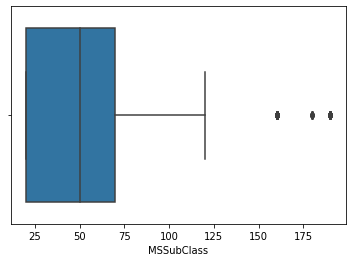

-----LotFrontage-----
Toplam Aykırı Değer Sayısı :106


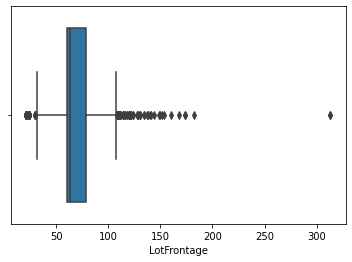

-----OverallCond-----
Toplam Aykırı Değer Sayısı :125


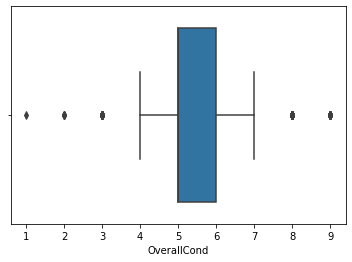

-----BsmtFinSF2-----
Toplam Aykırı Değer Sayısı :167


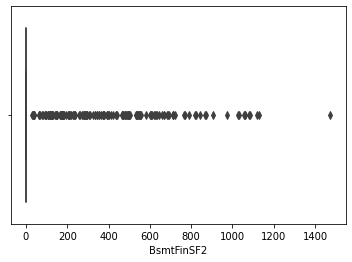

-----EnclosedPorch-----
Toplam Aykırı Değer Sayısı :208


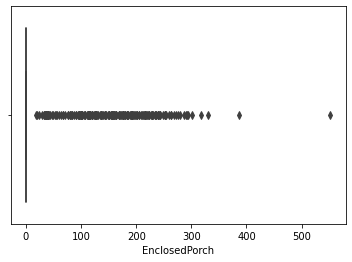

-----ScreenPorch-----
Toplam Aykırı Değer Sayısı :116


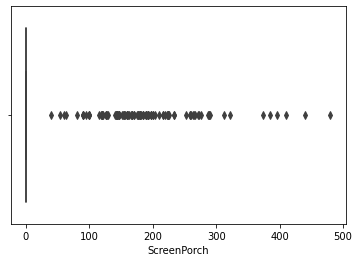

Toplam Değişken Sayısı : 6


In [40]:
def up_number_outliers(df, number,plot = False):
    
    out_features = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        Q1 = df[cols].quantile(0.25)
        Q3 = df[cols].quantile(0.75)
        IQR = np.multiply(1.5, np.subtract(Q3,Q1))
        
        alt_eşik = Q1 - IQR
        üst_eşik = IQR + Q3
        
        out_cols = df[cols][(df[cols] < alt_eşik) | (df[cols] > üst_eşik)].count()
        
        if out_cols > int(number):
            
            out_features.append(cols)
            
            print(f"-----{cols}-----\nToplam Aykırı Değer Sayısı :{out_cols}")
            
            if plot:
                
                sns.boxplot(df[cols]);
                plt.show()
                
    print(f"Toplam Değişken Sayısı : {len(out_features)}")
         
            
up_number_outliers(data, number=100, plot=True)

- Aykırı Değeri olan Değişkenlerimizin , **alt_eşik** ve **üst_eşik** değerleri,**0 olmayan** değişkenleri bize veren fonskiyon yazalım
- Aynı Zaman da **Alt Aykırı Değerlerin ve Üst Aykırı Değerlerin Toplam Sayısını** yazdıralım.

In [41]:
def analiz_eşik(df):
    
    out_value = []
    zero_alt_üst = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in  'Id']
    
    for cols in num_cols:
        
        alt,üst = alt_üst_eşik(df,feature = cols)
        
        if alt !=0 and üst!=0:
            
            alt_değer = df[cols][df[cols] < alt].count()
            üst_değer = df[cols][df[cols] > üst].count()
            out_value.append((cols,alt,üst,alt_değer,üst_değer))
            
            if alt_değer == 0 and üst_değer == 0:
                
                zero_alt_üst.append(cols)
            
            
    for i,j,k,f,y in out_value:
        
        print(f"Değişken : {i}\nAlt Eşik : {j}\nÜst Eşik :{k}\n"
              f"Toplam Alt Aykırı Değer : {f}\nToplam Üst Aykırı Değer :{y}",end = "\n\n\n")
        #print(i,j,k) #Bu şekilde de yazabiliriz.
        
    print(f"Alt Ve Üst Aykırı Değerleri Olmayan Değişkenler : {zero_alt_üst}")
                
analiz_eşik(data)

Değişken : MSSubClass
Alt Eşik : 55.0
Üst Eşik :145.0
Toplam Alt Aykırı Değer : 765
Toplam Üst Aykırı Değer :103


Değişken : LotFrontage
Alt Eşik : -31.5
Üst Eşik :107.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :58


Değişken : LotArea
Alt Eşik : -1481.5
Üst Eşik :17673.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :67


Değişken : OverallQual
Alt Eşik : -2.0
Üst Eşik :10.0
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : OverallCond
Alt Eşik : -3.5
Üst Eşik :7.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :94


Değişken : YearBuilt
Alt Eşik : -1885.0
Üst Eşik :2069.0
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : YearRemodAdd
Alt Eşik : -1911.5
Üst Eşik :2059.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : MasVnrArea
Alt Eşik : 246.375
Üst Eşik :410.625
Toplam Alt Aykırı Değer : 1223
Toplam Üst Aykırı Değer :98


Değişken : BsmtFinSF1
Alt Eşik : 1068.375
Üst Eşik :1780.625
Toplam Alt Aykırı Değer

- **Aykırı Değere sahip** değişkenlerimizin Aykırı Değerlerini, **alt_eşik** ve **üst_eşik** değerlerine baskılayacağız.

- Baskılama İşlemi Yaparken, **Toplam Alt ve Üst Değerlerin Sayısı 0 olan Değişkenleri** **almayacağız**.

- Bu Değişkenleri bize veren fonskiyon yazalım

In [42]:
def Zero_features(df):
    
    zero= []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        alt,üst = alt_üst_eşik(df,feature=cols)
        
        if alt != 0 and üst != 0:
            
            alt_değer = df[cols][df[cols] < alt].count()
            üst_değer = df[cols][df[cols] > üst].count()
            
            if alt_değer == 0 and üst_değer == 0:
                
                zero.append(cols)
                
    return zero

değişkenler = Zero_features(data)

değişkenler

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

- Aykırı Değere Sahip Değişkenlerimizi Alt ve Üst Eşik Değerlerine baskılayacağız.

In [43]:
def press_outliers(df):
    
    features = Zero_features(df) #Toplam alt ve üst aykırı değerleri 0 olan değişkenler
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id'
               and cols not in features]
    
    for cols in num_cols:
        
        alt_eşik, üst_eşik = alt_üst_eşik(df, feature = cols)
        
        if alt_eşik != 0 and üst_eşik !=0:
            
            alt = df[cols][df[cols] < alt_eşik].count()
            üst = df[cols][df[cols] > üst_eşik].count()
            
            if alt == 0 :  #alt aykırı değeri olmayanların üst aykırı değerleri vardı.Onları üst eşik değere baskıladık
                
                df[cols][(df[cols] > üst_eşik)] = üst_eşik
                
            elif üst == 0: #üst aykırı değeri olmayanların alt aykırı değerleri vardı.Onları alt eşik değere baskıladık
                
                df[cols][(df[cols] < alt_eşik)] = alt_eşik
                
            elif alt != 0 and üst != 0:
                
                df[cols][(df[cols] < alt_eşik)] = alt_eşik
                df[cols][(df[cols] > üst_eşik)] = üst_eşik 
            
            print(f"{cols} = {df[cols][(df[cols] < alt_eşik) | (df[cols] > üst_eşik)].count()}") #Değişkenlerimiz için Aykırı Değer kontrolü yapacak
    
    
press_outliers(data)    

MSSubClass = 0
LotFrontage = 0
LotArea = 0
OverallCond = 0
MasVnrArea = 0
BsmtFinSF1 = 0
BsmtUnfSF = 0
TotalBsmtSF = 0
1stFlrSF = 0
2ndFlrSF = 0
GrLivArea = 0
BsmtFullBath = 0
FullBath = 0
HalfBath = 0
BedroomAbvGr = 0
KitchenAbvGr = 0
TotRmsAbvGrd = 0
Fireplaces = 0
GarageCars = 0
GarageArea = 0
WoodDeckSF = 0
OpenPorchSF = 0


- Hedef Değişkenimizin **alt eşik ve üst eşik** değerlerine bakalım

In [44]:
alt_üst_eşik(data, feature='SalePrice')

(-3937.5, 340037.5)

- Hedef Değişkenimizin **Toplam Aykırı Değerlerini** bize veren fonksiyon yazalım.

In [45]:
def Target_Out(df,feature = 'SalePrice'):
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    IQR = np.multiply(1.5, np.subtract(Q3, Q1))
    
    alt_eşik = IQR - Q1
    üst_eşik = IQR + Q3
    
    alt = df[feature][df[feature] < alt_eşik].count()
    üst = df[feature][df[feature] > üst_eşik].count()
    
    return alt, üst
    
Target_Out(data,'SalePrice')

(0, 61)

- Hedef Değişkenimizin  **Alt Aykırı Değeri** yoktur.
- 61 tane **Üst Aykırı Değeri** vardır.
- Biz bu değerleri **Üst Eşik değerine baskılayacağız**

In [46]:
def Target_Press(df, target = 'SalePrice'):
    
    alt_eşik, üst_eşik = alt_üst_eşik(df, feature = target)
    
    df[target][df[target] > üst_eşik] = üst_eşik
    
    print(f"Aykırı Değer Sayısı : {df[target][df[target] > üst_eşik].count()}")

Target_Press(data, target='SalePrice')

Aykırı Değer Sayısı : 0


# Feature Engineering

- İlk olarak **agg** fonksiyonumuzu kullanarak,**Kategorik Değişkenlerimizin**,**Hedef Değişkenimize** etkisine bakacağız 

- İlk Olarak **Neighborhood** değişkenimiz ile başlayacağız

In [47]:
data.groupby('Neighborhood').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
Neighborhood,
NoRidge,297854.158537
NridgHt,288322.577922
StoneBr,275573.500000
Timber,239529.355263
Veenker,234685.227273
Somerst,224056.546512
ClearCr,212565.428571
Crawfor,208419.088235
CollgCr,197107.340000


- **Mahallelerin fiyata olan etkisini** görmüş olduk. 
- Şimdi ise bu **Mahalleleri SalePrice değişkenine etkisine göre numaralandıracağız.**. Şu şekide;

   - **MeadowW**  --> **1**
   - **NoRidge**  --> **10** şeklinde dönüştüreceğiz.

In [48]:
neih = {'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1,
                 'BrkSide': 2, 'Edwards': 2, 'OldTown': 2,
                 'Sawyer': 3, 'Blueste': 3,
                 'SWISU': 4, 'NPkVill': 4, 'NAmes': 4, 'Mitchel': 4,
                 'SawyerW': 5, 'NWAmes': 5,
                 'Gilbert': 6, 'Blmngtn': 6, 'CollgCr': 6,
                 'Crawfor': 7, 'ClearCr': 7,
                 'Somerst': 8, 'Veenker': 8, 'Timber': 8,
                 'StoneBr': 9, 'NridgHt': 9,
                 'NoRidge': 10}

data['Neighborhood'] = data['Neighborhood'].map(neih).astype('int')    

In [49]:
data['Neighborhood'].head()

0     6
1     8
2     6
3     7
4    10
Name: Neighborhood, dtype: int64

- **MoSold** değişkeninde aylara göre satış değerleri vardır.Bunları da Ay isimleri ile değiştireceğiz.

- Şu şekilde;

   - **1** --> **January**
   - **6** --> **June**


In [50]:
data['MoSold'].value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [51]:
data.groupby('MoSold').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
MoSold,
9,192358.539683
11,188689.512658
12,186518.966102
8,183579.286885
7,179516.072650
2,177882.000000
3,177496.075472
10,176303.337079
6,174797.881423


In [52]:
data = data.replace({"MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}})

data['MoSold'].value_counts()

Jun    253
Jul    234
May    204
Apr    141
Aug    122
Mar    106
Oct     89
Nov     79
Sep     63
Dec     59
Jan     58
Feb     52
Name: MoSold, dtype: int64

- **Functional** değişkeni ; **Evin işlevsellik derecesinin** olduğu değişkendir.
- Bu değişkenin, **Hedef Değişken** üzerinde ki etkisine bakalım.

In [53]:
data.groupby('Functional').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending=False)

,SalePrice
Functional,
Typ,179721.091912
Mod,155195.833333
Maj1,153948.142857
Min1,146385.483871
Min2,144240.647059
Sev,129000.000000
Maj2,85800.000000


In [54]:
data['Functional'].value_counts()

Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

- Evin işlevsellik değerlerinden SalePrice değişkenimize etkisi en çoktan en aza yukarıda gördüğümüz gibidir.
- Biz bu değerleri **Yüksekten Düşüğe** doğru numaralandıracağız.Şu Şekilde;

   - En Yüksek Değer -> **6** 'dan başlayarak **En Düşük** dereceye sahip sınıfa kadar numaralandıracağız.
   

In [55]:
func = {'Typ':6, 'Mod':5, 'Maj1':4, 'Min1':3,'Min2':2 ,'Sev':1 ,'Maj2':0}

data['Functional'] = data['Functional'].map(func).astype('int')

data['Functional'].value_counts()

6    1360
2      34
3      31
5      15
4      14
0       5
1       1
Name: Functional, dtype: int64

- Bazı kategorik değişkenlerimizin değerleri kendi aralarında belli bir derecelendirme halindedir.
- Bizde bunları ifade ettiği dereceye göre **Ordinal** hale getireceğiz.

- **MSZoning** Değişkeni, Genel **İmar Sınıflandırılması** olan değerlerden oluşur.


In [56]:
data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

- **MSZoning** değişkeninde ki değerlerin, **Hedef Değişkeni** miz üzerinde ki etkisine bakalım.

In [57]:
data.groupby('MSZoning').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
MSZoning,
FV,213539.592308
RL,186641.265856
RH,131558.375000
RM,125457.082569
C (all),74528.000000


In [58]:
data = data.replace({'MSZoning': {'FV':4, 'RL':3, 'RH':2, 'RM':1, 'C (all)':0}})

data['MSZoning'].value_counts()

3    1151
1     218
4      65
2      16
0      10
Name: MSZoning, dtype: int64

- **LotShape** Değişkeni, Mülkün Genel şeklini ifade eden değerleri bize verir.

- **LotShape** Değişkeninde ki değerlerin, **Hedef Değişkenimiz** üzerindeki etkisine bakalım

In [59]:
data.groupby('LotShape').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending=False)

,SalePrice
LotShape,
IR2,223401.439024
IR3,212540.250000
IR1,200291.106405
Reg,162895.428649


In [60]:
data = data.replace({'LotShape': {'IR2':4, 'IR3':3, 'IR1':2, 'Reg':1}})

data['LotShape'].value_counts()

1    925
2    484
4     41
3     10
Name: LotShape, dtype: int64

- **LandContour** Değişkeni, Mülkün Düzlüğünü ifade eden sınıfları içerir.

- Bu Sınıfların, **Hedef Değişken** üzerinde ki etkilerine bakalım.

In [61]:
data.groupby('LandContour').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
LandContour,
HLS,220184.570000
Low,201440.972222
Lvl,176679.914569
Bnk,143104.079365


In [62]:
data['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [63]:
data = data.replace({'LandContour':{'HLS':4, 'Low':3, 'Lvl':2, 'Bnk':1}})

data['LandContour'].value_counts()

2    1311
1      63
4      50
3      36
Name: LandContour, dtype: int64

- **LotConfig** Değişkeni, Arazi Yapılandırmasını ifade eden sınıfları içerir.

- Bu sınıların, **Hedef Değişken** üzerinde ki etkilerine bakalım

In [64]:
data.groupby('LotConfig').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
LotConfig,
CulDSac,213260.819149
FR3,208475.000000
Corner,177408.806084
FR2,176773.308511
Inside,174008.317490


- Yuakrıda gördüğümüz gibi **Hedef Değişken** üzerinde ki etkileri birbirlerine çok yakın değerler olduğu için **Ordinal** değer yaparken sadece 2 sınıf haline getireceğiz.
- 17... olanlar --> **1**
- 21 ve 20 olanlar --> **2** yapacağız.

In [65]:
data['LotConfig'].value_counts()

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

In [66]:
data = data.replace({'LotConfig':{'Inside':1, 'FR2':1, 'Corner':1, 'FR3':2,'CulDSac':2}})

data['LotConfig'].value_counts()

1    1362
2      98
Name: LotConfig, dtype: int64

- **Condition1** Değişkeni, AnaYola ve demiryoluna Yakınlığı ifade eden sınıfları barındırır.
- Bu sınıfların, **Hedef Değişken** üzerinde ki etkilerine bakalım

In [67]:
data.groupby('Condition1').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
Condition1,
PosA,225875.000000
PosN,212817.763158
RRNn,212400.000000
RRNe,190750.000000
RRAn,181205.750000
Norm,180544.674603
Feedr,142475.481481
RRAe,138400.000000
Artery,132279.947917


- **Hedef Değişken** etkileri, birbirine yakın olan sınıfları **Aynı Ordinal** değer yapacağız

In [68]:
data['Condition1'].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [69]:
data = data.replace({'Condition1':{'Artery':1,'RRAe':1,'Feedr':2,'Norm':3,'RRAn':4,'RRNe':5,
                                  'RRNn':6,'PosN':6,'PosA':7}})

data['Condition1'].value_counts()

3    1260
2      81
1      59
4      26
6      24
7       8
5       2
Name: Condition1, dtype: int64

- **BldgType** Değişkeni, Konut Tipini ifade eden sınıflardan oluşur.
- Bu sınıfların, Hedef Değişken üzerinde ki etkilerine bakalım.

In [70]:
data.groupby('BldgType').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BldgType,
1Fam,181533.316803
TwnhsE,181260.052632
Twnhs,135911.627907
Duplex,133541.076923
2fmCon,128432.258065


In [71]:
data['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

- Hedef Değişken etkileri, birbirine yakın olan sınıfları Aynı değer yapacağız

In [72]:
data = data.replace({'BldgType': {'2fmCon':1,'Duplex':2,'Twnhs':2,'TwnhsE':3,'1Fam':3}})

data['BldgType'].value_counts()

3    1334
2      95
1      31
Name: BldgType, dtype: int64

- **RoofStyle** Değişkeni, Çatı Stilini ifade eden sınıfların bulunduğu değişkendir.
- Bu sınıfların, Hedef Değişken üzerinde ki etkilerine bakalım.

In [73]:
data.groupby('RoofStyle').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
RoofStyle,
Shed,225000.000000
Hip,206094.054196
Flat,194690.000000
Mansard,180568.428571
Gable,170094.811569
Gambrel,148909.090909


In [74]:
data['RoofStyle'].value_counts()

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

In [75]:
data = data.replace({'RoofStyle': {'Gambrel':1, 'Gable':2, 'Mansard':3, 'Flat':4, 'Hip':5, 'Shed':6}})

data['RoofStyle'].value_counts()

2    1141
5     286
4      13
1      11
3       7
6       2
Name: RoofStyle, dtype: int64

- **RoofMatl** Değişkeni, Çatı Malzemesini ifade eden sınıflardan oluşur

In [76]:
data.groupby('RoofMatl').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
RoofMatl,
WdShngl,291102.083333
Membran,241500.000000
WdShake,241400.000000
Tar&Grv,185406.363636
Metal,180000.000000
CompShg,176563.769874
ClyTile,160000.000000
Roll,137000.000000


In [77]:
data = data.replace({'RoofMatl': {'Roll':1, 'ClyTile':2, 'CompShg':3, 'Metal':3, 'Tar&Grv':3, 'WdShake':4, 'Membran':4, 'WdShngl':5}})

data['RoofMatl'].value_counts()

3    1446
4       6
5       6
1       1
2       1
Name: RoofMatl, dtype: int64

- **ExterQual** Değişkeni, Dış Malzeme kalitesini ifade eden sınıfları barındırır.

In [78]:
data.groupby('ExterQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
ExterQual,
Ex,309806.519231
Gd,227226.761270
TA,144233.594923
Fa,87985.214286


In [79]:
data['ExterQual'].value_counts()

TA    906
Gd    488
Ex     52
Fa     14
Name: ExterQual, dtype: int64

In [80]:
data = data.replace({'ExterQual': {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}})

data['ExterQual'].value_counts()

2    906
3    488
4     52
1     14
Name: ExterQual, dtype: int64

- **ExterCond** Değişkeni,Malzemenin dış cephedeki mevcut durumunu ifade eden sınıfları barındırır.

In [81]:
data.groupby('ExterCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
ExterCond,
Ex,201333.333333
TA,180314.094774
Gd,165672.568493
Fa,102595.142857
Po,76500.000000


In [82]:
data['ExterCond'].value_counts()

TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [83]:
data = data.replace({'ExterCond': {'Po':1, 'Fa':2, 'Gd':3, 'TA':4, 'Ex':5}})

data['ExterCond'].value_counts()

4    1282
3     146
2      28
5       3
1       1
Name: ExterCond, dtype: int64

- **BsmtQual** Değişkeni, Bodrum Yükseliğini ifade eden sınıfları barındırır

In [84]:
data.groupby('BsmtQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtQual,
Ex,291029.326446
Gd,201543.535599
TA,138609.845481
Fa,115692.028571


In [85]:
data['BsmtQual'].value_counts()

TA    686
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [86]:
data = data.replace({'BsmtQual': {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}})

data['BsmtQual'].value_counts()

2    686
3    618
4    121
1     35
Name: BsmtQual, dtype: int64

- **BsmtCond** Değişkeni,

In [87]:
data.groupby('BsmtCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtCond,
Gd,210347.415385
TA,177761.140579
Fa,121809.533333
Po,64000.000000


In [88]:
data['BsmtCond'].value_counts()

TA    1348
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [89]:
data = data.replace({'BsmtCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4}})

data['BsmtCond'].value_counts()

3    1348
4      65
2      45
1       2
Name: BsmtCond, dtype: int64

- **BsmtFinType1** Değişkeni, Bitmiş Bodrum Alanının kalitesini ifade eden sınfları barındırır.

In [90]:
data.groupby('BsmtFinType1').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtFinType1,
GLQ,225698.870813
Unf,163619.581370
ALQ,160514.318182
LwQ,151852.702703
BLQ,149364.854730
Rec,146581.259398


In [91]:
data['BsmtFinType1'].value_counts()

Unf    467
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

- **BsmtFinType1** değişkenin sınıflarının , **Hedef Değişkene** etkisi yakın değer de olanları **Aynı Ordinal** değer yapıyoruz.

In [92]:
data = data.replace({'BsmtFinType1': {'Rec':1, 'BLQ':1, 'LwQ':1, 'ALQ':2, 'Unf':2, 'GLQ':3}})

data['BsmtFinType1'].value_counts()

2    687
3    418
1    355
Name: BsmtFinType1, dtype: int64

- **BsmtFinType2** Değişkeni, Bitmiş İkinci alanın Kalitesini ifade eden sınıfları içerir.

In [93]:
data.groupby('BsmtFinType2').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtFinType2,
ALQ,198628.289474
GLQ,180982.142857
Unf,178702.208655
LwQ,164364.130435
Rec,163122.222222
BLQ,151101.000000


In [94]:
data['BsmtFinType2'].value_counts()

Unf    1294
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [95]:
data = data.replace({'BsmtFinType2': {'BLQ':1, 'Rec':2, 'LwQ':2, 'Unf':3, 'GLQ':3, 'ALQ':4}})

data['BsmtFinType2'].value_counts()

3    1308
2     100
1      33
4      19
Name: BsmtFinType2, dtype: int64

- **BsmtExposure** Değişkeni,Grev veya bahçe seviyesi bodrum duvarlarını ifade eden sınıfları içerir.

In [96]:
data.groupby('BsmtExposure').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtExposure,
Gd,236992.391791
Av,200432.579186
Mn,189796.210526
No,162678.789102


In [97]:
data['BsmtExposure'].value_counts()

No    991
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

In [98]:
data = data.replace({'BsmtExposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4}})

data['BsmtExposure'].value_counts()

1    991
3    221
4    134
2    114
Name: BsmtExposure, dtype: int64

- **Heating** Değişkeni, Isıtma Türlerini ifade eden sınıfları içerir.

In [99]:
data.groupby('Heating').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
Heating,
GasA,178375.568627
GasW,164689.805556
OthW,125750.000000
Wall,92100.000000
Grav,75271.428571
Floor,72500.000000


In [100]:
data['Heating'].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [101]:
data = data.replace({'Heating': {'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5}})

data['Heating'].value_counts()

5    1428
4      18
1       8
2       4
3       2
Name: Heating, dtype: int64

- **HeatingQC** Değişkeni, Isıtma kalitesi ve durumunu ifade eden sınıfları içerir.

In [102]:
data.groupby('HeatingQC').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
HeatingQC,
Ex,208056.122807
Gd,156423.653527
TA,142236.649533
Fa,123919.489796
Po,87000.000000


In [103]:
data['HeatingQC'].value_counts()

Ex    741
TA    428
Gd    241
Fa     49
Po      1
Name: HeatingQC, dtype: int64

In [104]:
data = data.replace({'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}})

data['HeatingQC'].value_counts()

5    741
3    428
4    241
2     49
1      1
Name: HeatingQC, dtype: int64

- **KitchenQual** Değişkeni, Mutfak Kalitesini ifade eden sınıfları barındırır

In [105]:
data.groupby('KitchenQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
KitchenQual,
Ex,288718.080000
Gd,210062.724403
TA,139889.008163
Fa,105565.205128


In [106]:
data['KitchenQual'].value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64

- **map()** fonksiyonu kullanarak sınıfları **Ordinal** yapalım

In [107]:
kitqual = {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

data['KitchenQual'] = data['KitchenQual'].map(kitqual).astype('int')

data['KitchenQual'].value_counts()

2    735
3    586
4    100
1     39
Name: KitchenQual, dtype: int64

- **FireplaceQu** Değişkeni, Şömine kalitesini ifade eden sınıfları barındırır.

In [108]:
data.groupby('FireplaceQu').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
FireplaceQu,
Ex,294097.541667
Gd,218106.526316
TA,202341.715655
Fa,167298.484848
None,141327.706522
Po,129764.150000


In [109]:
data['FireplaceQu'].value_counts()

None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: FireplaceQu, dtype: int64

- Biz Bazı değişkenlerdeki **Eksik Değerleri**, **None** ile doldurmuştuk.Nu **None** değerleri bilmediğimiz için bunu ordinal yaparken derecesini **0** yaparız.

In [110]:
fire = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

data['FireplaceQu'] = data['FireplaceQu'].map(fire).astype('int')

data['FireplaceQu'].value_counts()

0    690
4    380
3    313
2     33
5     24
1     20
Name: FireplaceQu, dtype: int64

- **GarageCond** Değişkeni, Garaj Durumunu ifade eden sınıfarı içerir.

In [111]:
data.groupby('GarageCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
GarageCond,
Gd,179930.000000
TA,179292.300995
Ex,124000.000000
Fa,114654.028571
Po,108500.000000


In [112]:
data['GarageCond'].value_counts()

TA    1407
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

In [113]:
garage = {'Po':1, 'Fa':1, 'Ex':2, 'TA':3, 'Gd':3}

data['GarageCond'] = data['GarageCond'].map(garage).astype('int')

data['GarageCond'].value_counts()

3    1416
1      42
2       2
Name: GarageCond, dtype: int64

- **GarageQual** Değişkeni, Garaj Kalitesini ifade eden sınıfları içerir.

In [114]:
data.groupby('GarageQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
GarageQual,
Gd,215860.714286
Ex,196012.500000
TA,178923.793103
Fa,123573.354167
Po,100166.666667


In [115]:
data['GarageQual'].value_counts()

TA    1392
Fa      48
Gd      14
Po       3
Ex       3
Name: GarageQual, dtype: int64

In [116]:
garage_qua = {'Po':1, 'Fa':2, 'TA':3, 'Ex':4, 'Gd':5}

data['GarageQual'] = data['GarageQual'].map(garage_qua).astype('int')

data['GarageQual'].value_counts()

3    1392
2      48
5      14
1       3
4       3
Name: GarageQual, dtype: int64

- **PavedDrive** Değişknei, 

In [117]:
data.groupby('PavedDrive').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
PavedDrive,
Y,182522.841418
P,132330.000000
N,115039.122222


In [118]:
data['PavedDrive'].value_counts()

Y    1340
N      90
P      30
Name: PavedDrive, dtype: int64

In [119]:
pave = {'N':1, 'P':2, 'Y':3}

data['PavedDrive'] = data['PavedDrive'].map(pave).astype('int')

data['PavedDrive'].value_counts()

3    1340
1      90
2      30
Name: PavedDrive, dtype: int64

- **CentralAir** Değişkeni, Merkezi klima olup olmadığını ifade eder

In [120]:
data.groupby('CentralAir').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
CentralAir,
Y,182347.209890
N,105264.073684


In [121]:
data = data.replace({'CentralAir': {'Y':1, 'N':0}})

data['CentralAir'].value_counts()

1    1365
0      95
Name: CentralAir, dtype: int64

- **LandSlope** Değişkeni, Mülkün Eğimini ifade eden sınıfları içerir.

In [122]:
data.groupby('LandSlope').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
LandSlope,
Sev,201689.807692
Mod,191957.984615
Gtl,176414.465991


In [123]:
land = {'Gtl':1, 'Mod':2, 'Sev':3}

data['LandSlope'] = data['LandSlope'].map(land).astype('int')

data['LandSlope'].value_counts()

1    1382
2      65
3      13
Name: LandSlope, dtype: int64

- **PoolArea** Değişkenini, Metrekare cinsinden havuz alanını ifade eder.
- **0** Havuz alanı olmadığını, 
- Diğer Değerler ise de Havuz Alanının kaç metrekare olduğunu ifade eder.
- Biz **PoolArea** Değişkenini kullanarak yeni değişken elde edeceğiz.**Bu değişken bize Evin Havuzu var mı yok mu onun sınıfını döndürecek**

In [124]:
data['PoolArea'].value_counts()

0      1453
480       1
512       1
519       1
555       1
576       1
648       1
738       1
Name: PoolArea, dtype: int64

In [125]:
data['PoolVr'] = data['PoolArea'].apply(lambda i: 1 if i>0 else 0)

data['PoolVr'].value_counts()

0    1453
1       7
Name: PoolVr, dtype: int64

- **CentralAir** değişkenini kullanarak yeni değişken elde edeceğiz.
- **Merkezi Klima** bulunan evlerde klima vardır.Olmayan evlerde yoktur.Biz Evde klima olup olmadığını bize veren yeni değişken elde edeceğiz

In [126]:
data['CentralAir'].value_counts()

1    1365
0      95
Name: CentralAir, dtype: int64

In [127]:
data['CentralAirVr'] = data['CentralAir'].apply(lambda i: 1 if i>0 else 0)

data['CentralAirVr'].value_counts()

1    1365
0      95
Name: CentralAirVr, dtype: int64

- **FirePlaces** Değişkenini kullanarak yeni değişken elde edeceğiz.
- FirePlaces değişkeniz bizlere şömine sayısını veren değerlerden oluşur.
- Bizde bu değerleri kullanarak evin şöminesinin olup olamdığını bize veren değişken elde edeceğiz

In [128]:
data['Fireplaces'].value_counts()

1.5    1340
2.0     115
2.5       5
Name: Fireplaces, dtype: int64

In [129]:
data['FireplacesVr'] = data['Fireplaces'].apply(lambda i: 1 if i>0 else 0)

data['FireplacesVr'].value_counts()

1    1460
Name: FireplacesVr, dtype: int64

- **GarageCars** Değişkeni, bizlere Araba kapasitesindeki garajın büyüklüğünü ifade eden değereri verir.
- Bizde bu değerleri kullanarak, Evin Garajı olup olmadığını bize veren yeni değişken elde edeceğiz

In [130]:
data['GarageCars'].value_counts()

2.0    824
1.0    369
3.0    181
0.5     81
3.5      5
Name: GarageCars, dtype: int64

In [131]:
data['GarageVr'] = data['GarageCars'].apply(lambda i: 1 if i>0 else 0)

data['GarageVr'].value_counts()

1    1460
Name: GarageVr, dtype: int64

# Label Encoder

In [132]:
data.head(n=8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PoolVr,CentralAirVr,FireplacesVr,GarageVr
0,1,60,3,65.0,8450.0,Pave,None,1,2,AllPub,...,0,Feb,2008,WD,Normal,208500.0,0,1,1,1
1,2,55,3,80.0,9600.0,Pave,None,1,2,AllPub,...,0,May,2007,WD,Normal,181500.0,0,1,1,1
2,3,60,3,68.0,11250.0,Pave,None,2,2,AllPub,...,0,Sep,2008,WD,Normal,223500.0,0,1,1,1
3,4,70,3,60.0,9550.0,Pave,None,2,2,AllPub,...,0,Feb,2006,WD,Abnorml,140000.0,0,1,1,1
4,5,60,3,84.0,14260.0,Pave,None,2,2,AllPub,...,0,Dec,2008,WD,Normal,250000.0,0,1,1,1
5,6,55,3,85.0,14115.0,Pave,None,2,2,AllPub,...,700,Oct,2009,WD,Normal,143000.0,0,1,1,1
6,7,55,3,75.0,10084.0,Pave,None,1,2,AllPub,...,0,Aug,2007,WD,Normal,307000.0,0,1,1,1
7,8,60,3,60.0,10382.0,Pave,None,2,2,AllPub,...,350,Nov,2009,WD,Normal,200000.0,0,1,1,1


- 2 tane **Benzersiz Değeri** olan **Object** değişkenlerimize **Label Encoder** uyguladık.

In [133]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

def Label(df):
    
    cat_cols = [cols for cols in df.columns if df[cols].nunique() == 2
               and df[cols].dtypes == 'object']
    
    for cols in cat_cols:
        
        df[cols] = label_enc.fit_transform(df[cols])
        
Label(data)

In [134]:
data['Utilities'].value_counts()

0    1459
1       1
Name: Utilities, dtype: int64

In [135]:
data['Street'].value_counts()

1    1454
0       6
Name: Street, dtype: int64

# One Hot Encoder

- **10 Benzersiz Değeri olan** Değişkenlere Bakalım

In [136]:
cat_cols = [cols for cols in data.columns if data[cols].dtypes == 'object'
and data[cols].nunique() < 10]

cat_cols

['Alley',
 'Condition2',
 'HouseStyle',
 'MasVnrType',
 'Foundation',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

- **10 Benzsersiz Değerden Fazla Değeri olan** Değişkenlere bakalım

In [137]:
cat_but = [cols for cols in data.columns if data[cols].dtypes == 'object'
and cols not in cat_cols]

cat_but

['Exterior1st', 'Exterior2nd', 'MoSold']

- 10 tane Benzersiz Değerden fazla değeri olan değişkenlerin **Benzersiz Değer** Sayısını veren fonksiyon yazalım.

In [138]:
def cat_on(df):
    
    for cols in cat_but:
        
        print(f"'{cols}' Değişkenin Benzersiz Değer Sayısı : {df[cols].nunique()} ", end="\n\n")

cat_on(data)

'Exterior1st' Değişkenin Benzersiz Değer Sayısı : 15 

'Exterior2nd' Değişkenin Benzersiz Değer Sayısı : 16 

'MoSold' Değişkenin Benzersiz Değer Sayısı : 12 



- Benzersiz değer sayısı en fazla **16** olduğunu gördük.
- O yüzden **object** değişkenlerimizi **nunique()** kullanarak alırken hepsini alabilmek için **<= 16** demeliyiz.

In [139]:
[cols for cols in data.columns if data[cols].dtypes == 'object'
and data[cols].nunique() <= 16 ]

['Alley',
 'Condition2',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MoSold',
 'SaleType',
 'SaleCondition']

- Bu **Object** değişkenlerimize One Hot Encoder Uygulayacağımız fonskiyon yazalım

In [140]:
def OneHot(df, number = 16):
    
    cat_cols = [cols for cols in df.columns if df[cols].dtypes == 'object'
               and df[cols].nunique() <= int(number)]
    
    df = pd.get_dummies(df, columns = cat_cols, drop_first = True)
    
    return df 

OneHot(data, number = 16)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1456,1457,55,3,85.0,13175.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1457,1458,70,3,66.0,9042.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1458,1459,55,3,68.0,9717.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0


In [141]:
data = OneHot(data, number = 16)

data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1456,1457,55,3,85.0,13175.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1457,1458,70,3,66.0,9042.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1458,1459,55,3,68.0,9717.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0


In [142]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0


# Data Preprocessing

In [143]:
data_x = data.copy()

data_x.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600.0,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260.0,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0


In [144]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def Preprocessing(df, hedef = 'SalePrice', drops = ['Id','SalePrice']):
    
    y = df[hedef].values
    x = df.drop(drops, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 18)
    
    min_max = MinMaxScaler()
    
    x_train = min_max.fit_transform(x_train)
    x_test = min_max.fit_transform(x_test)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = Preprocessing(data_x, hedef = 'SalePrice', drops = ['Id','SalePrice'])

In [145]:
print(f"X_train : {x_train.shape}\nX_test : {x_test.shape}\nY_train : {y_train.shape}\nY_test : {y_test.shape}")

X_train : (978, 166)
X_test : (482, 166)
Y_train : (978,)
Y_test : (482,)


# Model

In [148]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


models = [('Linear Regression', LinearRegression()),
          ('Lasso', Lasso()),
          ('Ridge', Ridge()),
          ('Easticnet', ElasticNet()),
          ('RF',RandomForestRegressor())]

def Model(data_train,data_test,data_x_test, data_y_test):
    
    score = []
    
    for name,model in models:
        
        data_model = model # Model == linearRegressin() olduğu için direk eşittir model dedik.
        
        data_model.fit(data_train, data_test)
        
        y_pred = data_model.predict(data_x_test)
        
        mse = mean_squared_error(y_pred, data_y_test)
        
        rmse = np.sqrt(mse)
        
        score.append((name + ":" + str(rmse)))        
        
    return score

Model(x_train,y_train,x_test,y_test)

['Linear Regression:3.137493422392021e+16',
 'Lasso:25218.686307927284',
 'Ridge:22639.213298824747',
 'Easticnet:36162.924514564445',
 'RF:21167.710541374145']